# Import

In [19]:
# Packages
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from numpy import array, mean, append, unique
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display, Markdown
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha, pairwise_corr, linear_regression
from xgboost import XGBRegressor
from dalex import Explainer
from warnings import filterwarnings
filterwarnings('ignore')

# Setup

In [2]:
# Load data and setup output dir
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

In [3]:
# Clean data
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

In [4]:
# Composite values
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

In [5]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    "n_interm",
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    "diff_event2",
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    "gender_number",
    "hand_number",
    "enjoyment",
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sri" # dependent variable
]

labels = ["sbst", "sri"]
protecteds = ["gender_number", "hand_number"]
corr_extras = ["so", "mr", "sv"]
everything = features + labels + corr_extras

# Descriptive Stats

In [6]:
# Display how many missing values are in each column
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_events         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non

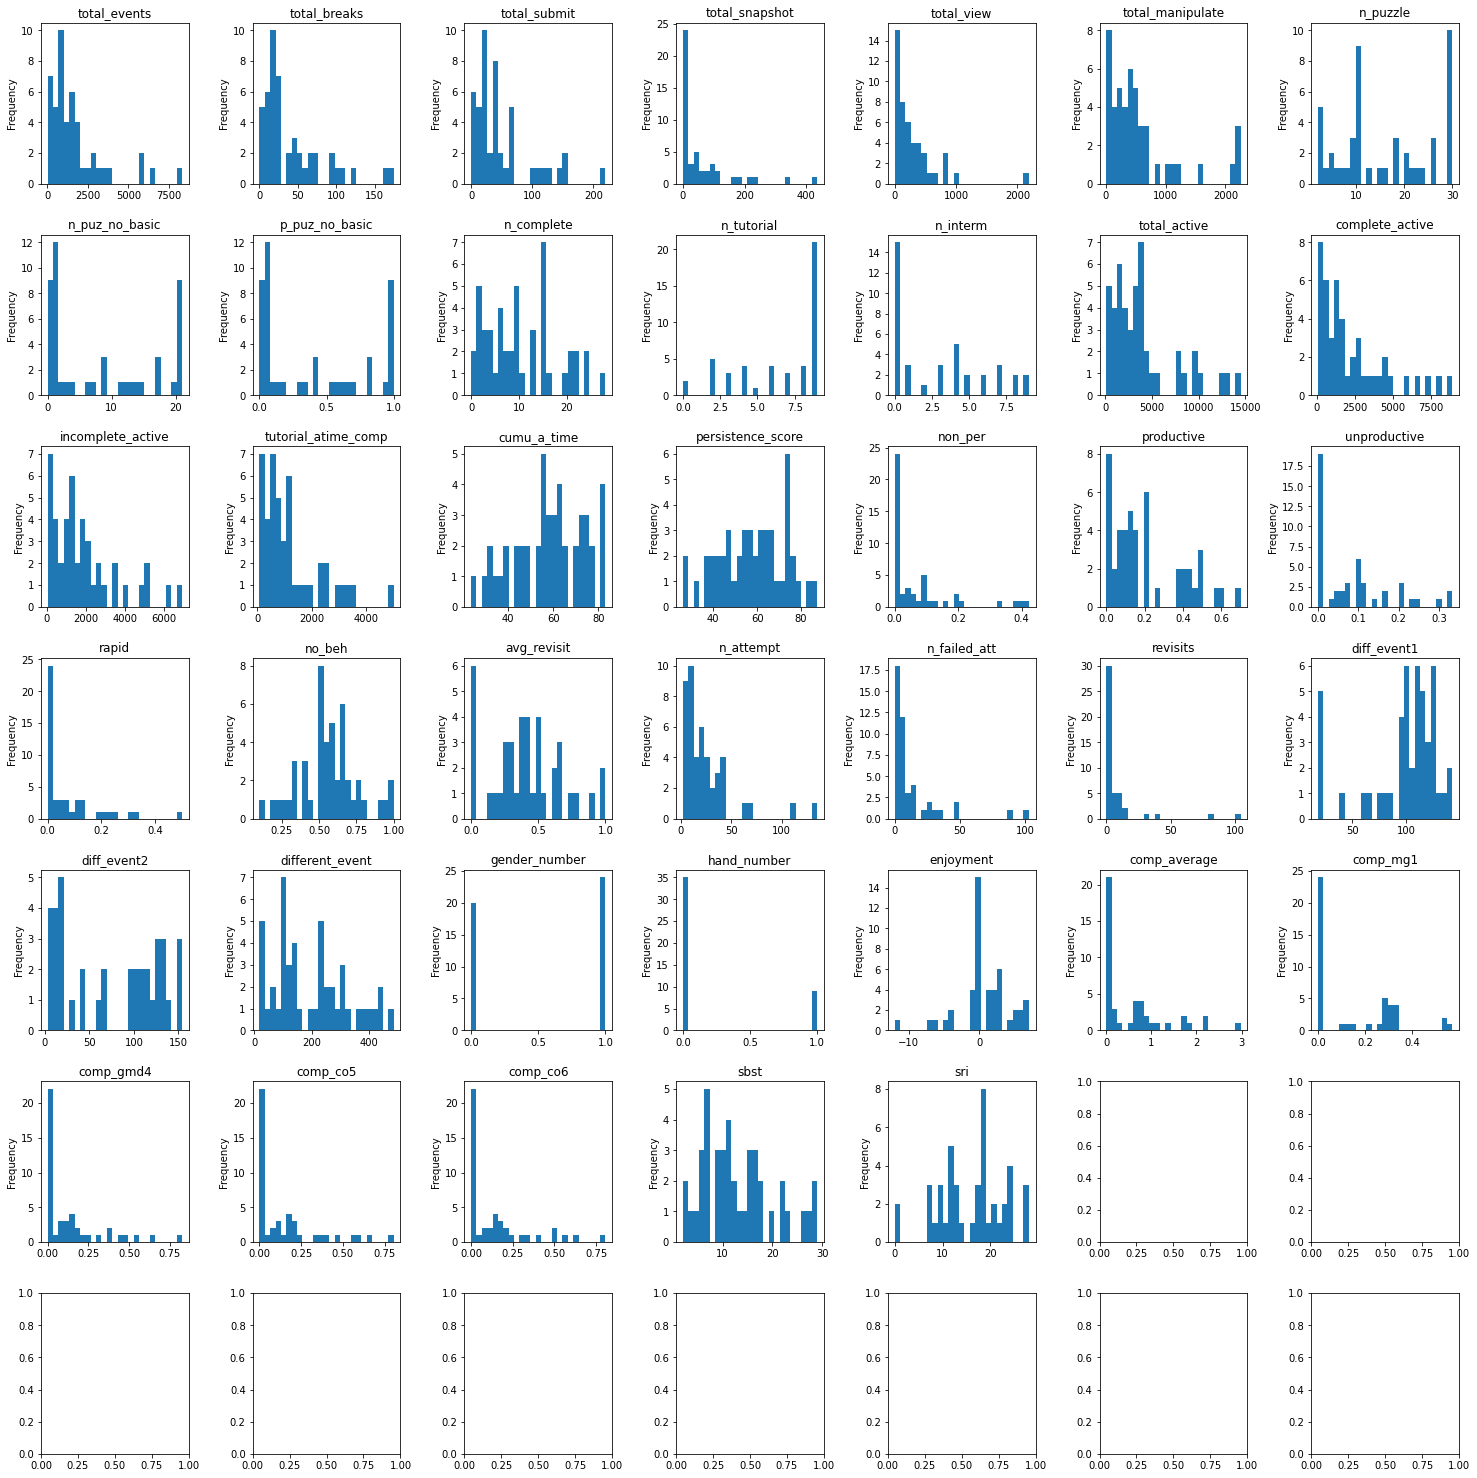

In [7]:
# Make a histogram for each feature and label
N = ceil(sqrt(len(features + labels)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(features + labels):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

In [8]:
# Percentages for the binary variables, gender and handedness
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15


In [9]:
# Correlation analysis
corr = pairwise_corr(data[features + labels + corr_extras])
corr.to_csv("output/corr.csv", sep="\t")
display(corr)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,total_events,total_breaks,pearson,two-sided,47,0.645940,"[0.44, 0.79]",9.422787e-07,2.084e+04,0.999264
1,total_events,total_submit,pearson,two-sided,47,0.831245,"[0.71, 0.9]",4.723115e-13,1.794e+10,1.000000
2,total_events,total_snapshot,pearson,two-sided,47,0.878537,"[0.79, 0.93]",4.868513e-16,1.23e+13,1.000000
3,total_events,total_view,pearson,two-sided,47,0.873332,"[0.78, 0.93]",1.182286e-15,5.292e+12,1.000000
4,total_events,total_manipulate,pearson,two-sided,47,0.969912,"[0.95, 0.98]",2.981582e-29,4.834e+25,1.000000
...,...,...,...,...,...,...,...,...,...,...
898,sri,mr,pearson,two-sided,44,0.891088,"[0.81, 0.94]",5.306859e-16,1.082e+13,1.000000
899,sri,sv,pearson,two-sided,44,0.865925,"[0.77, 0.93]",3.236657e-14,2.203e+11,1.000000
900,so,mr,pearson,two-sided,44,0.610590,"[0.38, 0.77]",1.076214e-05,2199.77,0.995703
901,so,sv,pearson,two-sided,44,0.617640,"[0.39, 0.77]",7.954919e-06,2907.53,0.996541


In [10]:
# # p values
# pvals = DataFrame(calculate_pvalues(data[everything + corr_extras]))
# pvals.to_csv("output/pvals.csv", sep="\t")
# display(pvals)

In [11]:
# Cronbach's Alpha
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


# ANOVA

In [12]:
# ANOVA with SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
display(aov)
print()

aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
display(aov)
print()

aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
display(aov)
print()

ANOVA of sri between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,1.777605,0.18963,0.040605



ANOVA of sbst between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,39,1.834019,0.183449,0.044914



ANOVA of n_complete between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,0.614792,0.437389,0.014427


# Random Forest and XGB

In [24]:
# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(data, label, features, protecteds, model):    
    # Split into train and test
    train_features, test_features, train_labels, test_labels = train_test_split(
        data[features],
        data[label],
        test_size=0.25,
        random_state=42
    )
    
    # print("Training Features Shape:", train_features.shape)
    # print("Training Labels Shape:", train_labels.shape)
    # print("Testing Features Shape:", test_features.shape)
    # print("Testing Labels Shape:", test_labels.shape)
    
    # Fit model
    model.fit(train_features, train_labels)
    
    # Check goodness
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mae = round(mean(errors), 2)
    display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
    
    # Explain features
    explain = Explainer(model, test_features, test_labels, verbose=False)
    explain.model_parts().plot()
    
    # Check fairness
    for col in protecteds:
        display(Markdown(f"## {col}"))
        explain.model_fairness(protected=test_features[col], privileged=0.0).plot()
        for c in unique(test_features[col].values):
            rows = test_features[col] == c
            display(linear_regression(model.predict(test_features[rows]), test_labels[rows]))
    
#     # Check goodness, for comparing between subgroups
#     data["Predicted"] = model.predict(array(data[features]))
#     data["Errors"] = data["Predicted"] - data[label]
#     data["Errors^2"] = data["Errors"]**2
#     data["Variance"] = (data[label] - data[label].mean())**2
#     for col in metadata:
#         data["Category"] = data[col].astype("category").cat.codes
#         data["WithinGroupTSS"] = data["Category"].map(lambda c: sum(data[data["Category"] == c]["Variance"]))
#         data["WithinGroupRSS"] = data["Category"].map(lambda c: sum(data[data["Category"] == c]["Errors^2"]))
#         data["E^2/wgTSS"] = data["Errors^2"] / data["WithinGroupTSS"]
#         print(f"Correlations between Error and {col}:")
#         display(pairwise_corr(data[["Errors", "Category"]]))
#         display(pairwise_corr(data[["Errors^2", "Category"]]))
#         display(pairwise_corr(data[["E^2/wgTSS", "Category"]]))
#         for c in unique(data["Category"].values):
#             rows = data["Category"] == c
#             display(linear_regression(data[rows]["Predicted"], data[rows][label]))
    
#     # Display importance of each features
#     gini_importances = list(model.feature_importances_)
#     importances = [
#         (feature, round(gini, 2))
#         for feature, gini
#         in zip(list(data.drop(label, axis=1).columns), gini_importances)
#     ]

#     importances = sorted(importances, reverse=True, key=lambda x: x[1])
#     for feature, gini in importances:
#         print(f"Variable: {feature:20} Gini Importance: {gini:<5}")
    
#     # Plot actual vs. predicted, color coded for each subgroup
#     for i, col in enumerate(metadata):
#         ax = ax_row[i]
#         for group, subdata in data.groupby(col):
#             ax.plot(
#                 subdata[label], # x
#                 subdata["Predicted"], # y
#                 marker="o",
#                 linestyle="",
#                 label=group
#             )
#             ax.set_title(title)
#             ax.legend(numpoints=1)

---

# sbst xgb full

**Mean Absolute Error:** 5.0 degrees.

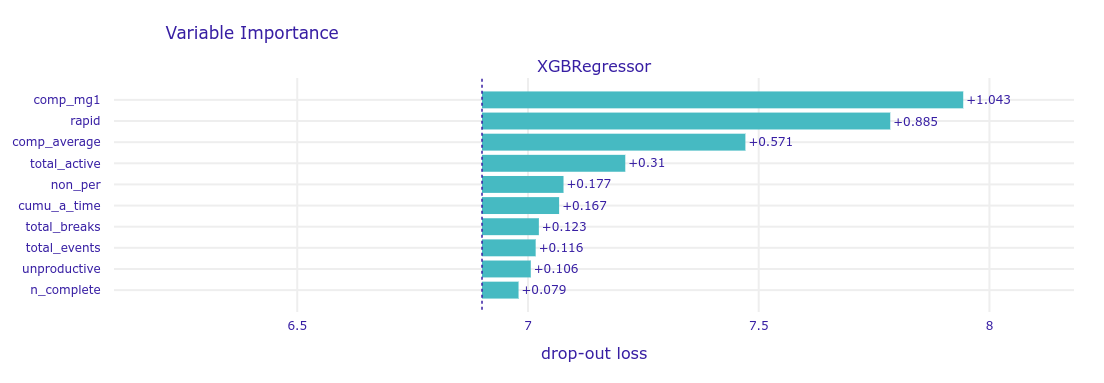

## gender_number

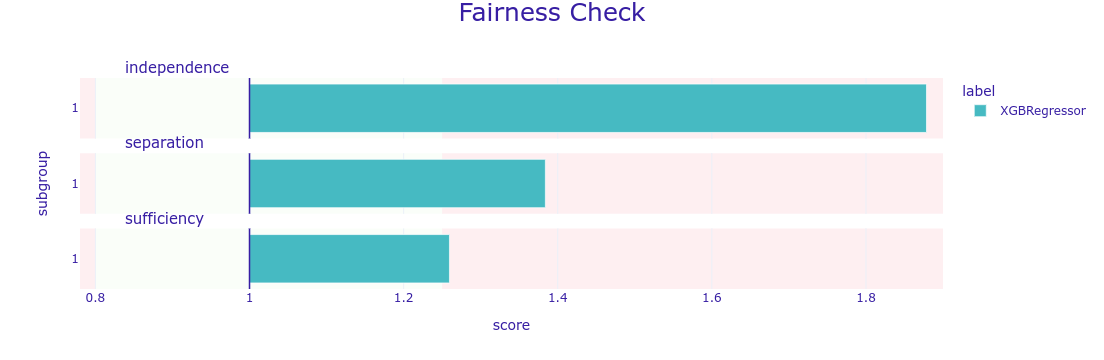

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,78.134768,47.978505,1.628537,0.350577,0.581999,0.163997,-531.489933,687.759470
1,x1,-4.012442,3.400452,-1.179973,0.447561,0.581999,0.163997,-47.219282,39.194397


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,20.543873,18.638297,1.102240,0.350848,0.075124,-0.233168,-38.771506,79.859251
1,x1,-0.906821,1.837020,-0.493637,0.655441,0.075124,-0.233168,-6.753039,4.939397


## hand_number

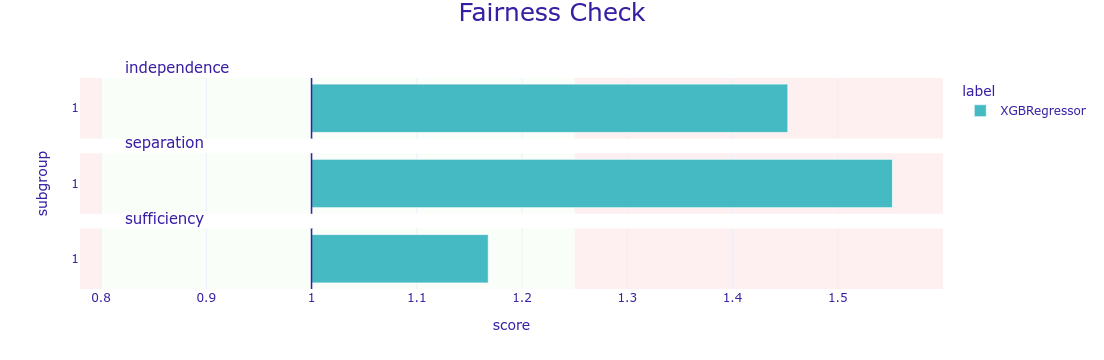

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-26.898050,20.758581,-1.295756,0.324447,0.688385,0.532578,-116.215016,62.418915
1,x1,4.275705,2.034165,2.101946,0.170310,0.688385,0.532578,-4.476602,13.028012


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-19.003463,11.626642,-1.634476,0.243777,0.806342,0.709513,-69.028865,31.021938
1,x1,2.544689,0.881816,2.885738,0.102035,0.806342,0.709513,-1.249457,6.338836


---

# sbst rf full

**Mean Absolute Error:** 4.99 degrees.

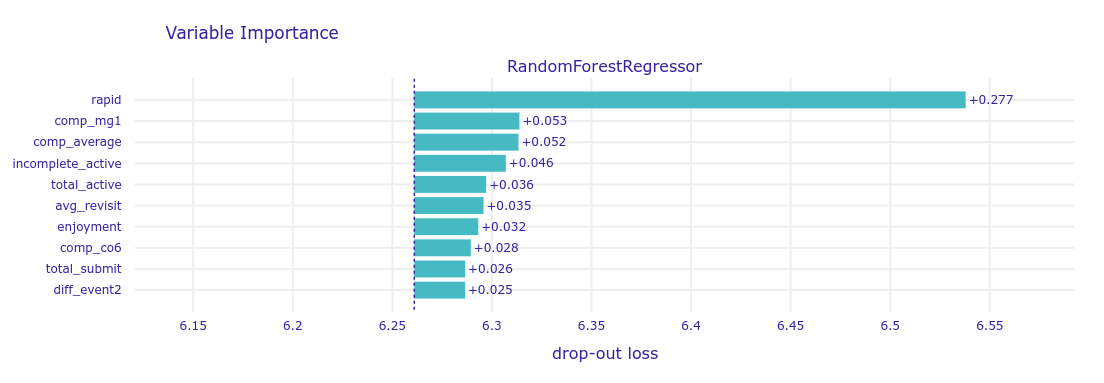

## gender_number

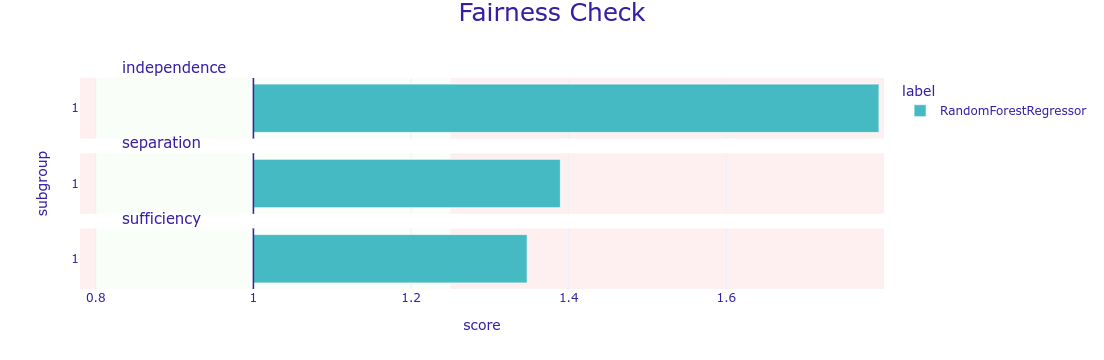

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,72.935739,84.537654,0.862760,0.546819,0.269467,-0.461066,-1001.217004,1147.088482
1,x1,-3.164627,5.210627,-0.607341,0.652533,0.269467,-0.461066,-69.371916,63.042661


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,26.969000,11.167301,2.414997,0.094592,0.398546,0.198061,-8.570335,62.508334
1,x1,-1.425733,1.011206,-1.409933,0.253351,0.398546,0.198061,-4.643841,1.792376


## hand_number

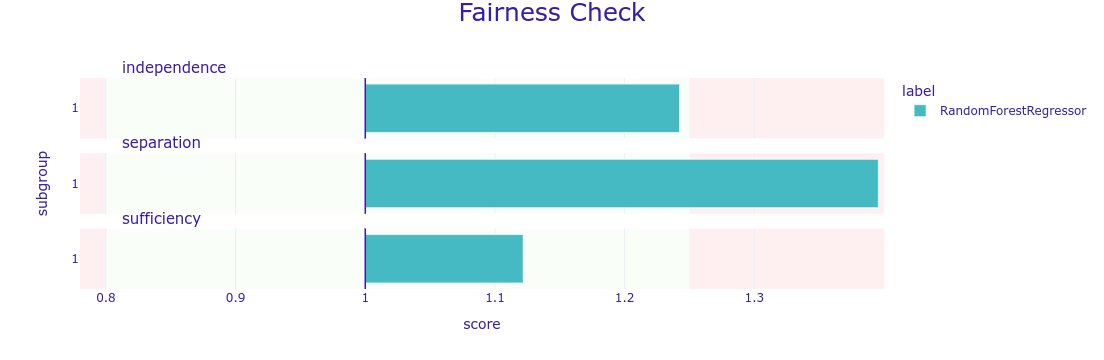

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-3.581694,16.752857,-0.213796,0.850522,0.427685,0.141527,-75.663420,68.500032
1,x1,1.725508,1.411426,1.222529,0.346024,0.427685,0.141527,-4.347366,7.798382


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-7.199607,19.164153,-0.375681,0.743258,0.39005,0.085074,-89.656301,75.257086
1,x1,1.499212,1.325670,1.130909,0.375461,0.39005,0.085074,-4.204687,7.203112


---

# sri xgb full

**Mean Absolute Error:** 3.63 degrees.

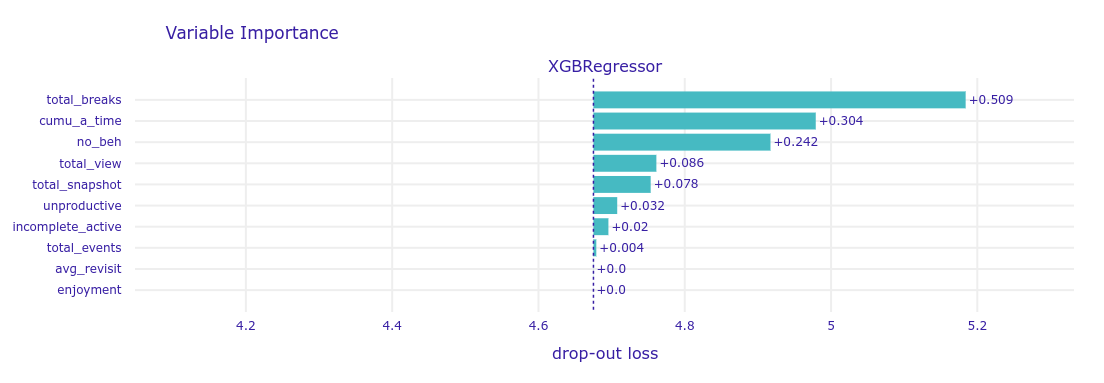

## gender_number

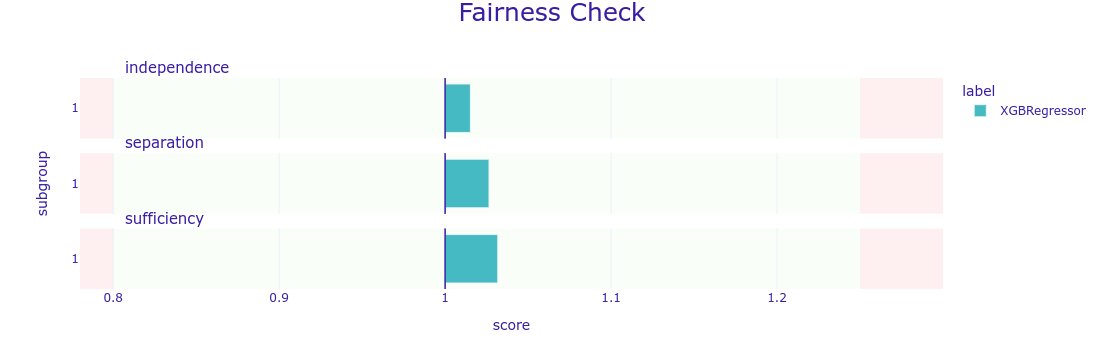

AssertionError: At least three valid samples are required in X.

In [25]:
# specify the models
label_dict = {
    label: data[data[label] > 0][everything].dropna()
    for label in labels
}

model_dict = {
    "xgb": XGBRegressor(tree_method="hist", random_state=42),
    "rf": RandomForestRegressor(n_estimators=1000, random_state=42)
}

# # setup figure that we'll add all the prediction plots to
# cols = max(len(metadata) + 1, 2)
# rows = max(len(label_dict) * len(model_dict), 2)
# fig, axs = subplots(rows, cols)
# fig.set_size_inches(3.25*cols, 3.1*rows)
# fig.tight_layout(pad=5.0)

# run the models
# i = 0
for L in label_dict:
    for M in model_dict:
        title = f"{L} {M} full"
        display(Markdown(f"---\n\n# {title}"))
        run_regressor(label_dict[L], L, features, protecteds, model_dict[M])
        # i += 1

# # save the plot now that we're done
# fig.savefig(f"output/predictions.png")